# Muti-agent reinforcement learning for Precision Agriculture

[(43, 24), (20, 47), (13, 34), (12, 9), (22, 0)]
LINEARRING (43 24, 20 47, 13 34, 12 9, 22 0, 43 24)
(array('d', [43.0, 20.0, 13.0, 12.0, 22.0, 43.0]), array('d', [24.0, 47.0, 34.0, 9.0, 0.0, 24.0]))
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
points: {(15.0, 21.0), (26.0, 21.0), (38.0, 23.0), (18.0, 17.0), (15.0, 30.0), (26.0, 30.0), (18.0, 26.0), (26.0, 39.0), (18.0, 35.0), (27.0, 13.0), (29.0, 32.0), (19.0, 9.0), (19.0, 18.0), (21.0, 37.0), (30.0, 18.0), (41.0, 24.0), (33.0, 20.0), (33.

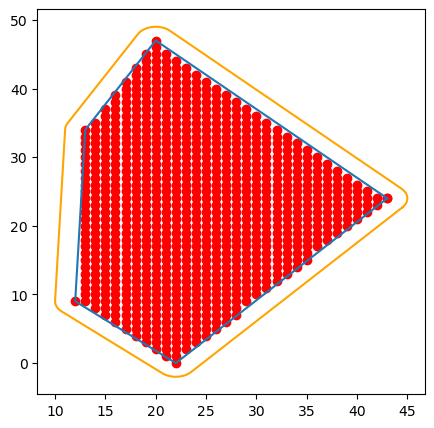

In [1]:
# Create a random shaped ag field
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)
from shapely import Polygon
from shapely.geometry import Point
from scipy.spatial import ConvexHull
import numpy as np
np.random.seed(33)
# Take random x,y values
x = [int(np.random.random()*100/2) for i in range(5)]
y = [int(np.random.random()*100/2) for i in range(5)]
# Make polygon using the values
ps = zip(x,y)
points = list(ps)
Poly = Polygon(points)
# Take the convex hull
hull = ConvexHull(points)
hull_points = [points[i] for i in hull.vertices]
inner_points = [point for i, point in enumerate(points) if i not in hull.vertices]
polygon = hull_points + inner_points
print(polygon)
p2 = Polygon(polygon)
Poly = p2
l = Poly.exterior
print(l)
print(l.xy)
p2.exterior

# Polygon exterior points
xp,yp = Poly.exterior.xy

# Gridpoints
xs = np.arange(0, 90, 1)
ys = np.arange(0, 90, 1)

# Inside points
print(xs,ys)
xps, yps = [], []
for xi in xs:
    for yi in ys:
        p = Point(xi,yi)
        if Poly.contains(p):
            xps += [p.x]
            yps += [p.y]
xps += xp
yps += yp

plt.plot(xp,yp)
plt.scatter(xps,yps, color='r')

points = set(list(zip(xps,yps)))
print('points:', points)
print(len(points))
print(len(xps))
print('xp, yp:',xp,yp)

buff = Poly.buffer(distance=2)
print('Buff:', buff)
x1,y1 = buff.exterior.xy
plt.plot(x1,y1, color='orange')
print("buff", x1,y1)
print("xps, yps", xps,yps)
pol_points = polygon
print(pol_points)

Make the multi-agent class:

In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pygame

class ThreeAgentGridworldEnv(gym.Env):
    metadata = {'render_modes': ['human', 'print', 'rgb_array'], "render_fps": 4}    
    def __init__(self, render_mode=None, grid_size=(50, 50), poly_points=pol_points):        
        super(ThreeAgentGridworldEnv, self).__init__()        
        self.Poly = Polygon(poly_points) # Get the points of the polygon
        self.poly_points = poly_points
        self.size = grid_size[0]  # The size of the square grid
        self.window_size = 800  # The size of the PyGame window        
        self.grid_size = grid_size # Size of the grid
        self.outer_boundary = self.Poly.buffer(distance=2)

        # Observation and action space
        self.observation_points = self.obs_points()
        print('Observation points:', self.observation_points)
        self.observation_length = len(self.observation_points)
        self.observation_map = {tuple(self.observation_points[i]):i for i in range(self.observation_length)}
        # for p in self.observation_points:
        #     print('observation map:', p, self.observation_map[tuple(p)])
        
        # Action and observation space
        self.action_space = spaces.MultiDiscrete([5, 5, 5])  # 4 possible actions for each of the two agents
        self.observation_space = spaces.MultiDiscrete([self.observation_length, self.observation_length, self.observation_length])
        
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode
        # If human-rendering is used, `self.window` will be a reference
        # to the window that we draw to. `self.clock` will be a clock that is used
        # to ensure that the environment is rendered at the correct framerate in
        # human-mode. They will remain `None` until human-mode is used for the
        # first time.
        self.window = None
        self.clock = None

        # Keep track of visited states and count steps
        self.step_count = 0
        self.visited = set()

        # Reset the environment and start
        self.reset()
        

    def reset(self, seed=None, options={}):
        self.visited = set()
        self.step_count = 0
        self.infected_locations = {(15,10), (22,13), (25,20), (26,21), (35,25)}
        self.agent_positions = [
            np.array([14, 34]),  # Agent 1 
            # np.array([self.grid_size[0]-1, self.grid_size[1]-1]),  # Agent 2 starts at bottom-right corner,
            # np.array([self.grid_size[0]-3, self.grid_size[1]-3])  # Agent 3 starts at specific position,
            np.array([80/2, 50/2]),  # Agent 2 
            np.array([40/2, 80/2]),  # Agent 3
        ]      
        return self._get_obs()

    def _get_obs(self):
        a1, a2, a3 = self.agent_positions[0], self.agent_positions[1], self.agent_positions[2]
        info = {'agent1': a1, 'agent2': a2, 'agent3': a3, 'step_count': self.step_count}
        # print('agent positions:', a1, a2, a3)
        p1,p2,p3 = self.observation_map[tuple(a1)], self.observation_map[tuple(a2)], self.observation_map[tuple(a3)]
        return np.array([p1,p2,p3]), info
    
    def obs_points(self):
        xp,yp = self.outer_boundary.exterior.xy
        # Gridpoints
        xs = np.arange(0, 90, 1)
        ys = np.arange(0, 90, 1)
        # Inside points
        # print(xs,ys)
        xps, yps = [], []
        for xi in xs:
            for yi in ys:
                p = Point(xi,yi)
                if self.outer_boundary.contains(p):
                    xps += [p.x]
                    yps += [p.y]
        xps += xp
        yps += yp
        # plt.plot(xp,yp)
        # plt.scatter(xps,yps, color='r')
        obs_points = np.array(list(zip(xps,yps)))
        return obs_points

    def step(self, action):
        # Placeholder for terminal state and rewards
        terminated, truncated = False, False
        rewards = 0
        self.step_count += 1

        # Define the movements corresponding to each action
        movements = [(-1, 0), (1, 0), (0, -1), (0, 1), (0, 0)]  # up, down, left, right
        
        # Update the positions of both agents
        for i, act in enumerate(action):
            if act==4:
                terminated = True
                break

            movement = movements[act]
            new_position = self.agent_positions[i] + movement
            
            # Ensure the new position is within bounds
            # new_position = np.clip(new_position, [0, 0], [self.grid_size[0]-1, self.grid_size[1]-1])
            new_p = Point(new_position[0], new_position[1])
            # print("checking new position", tuple(new_position))
            if self.Poly.contains(new_p):
                self.agent_positions[i] = new_position
            else:
                rewards -= 10
            if tuple(new_position) in self.visited:
                rewards -= 100
            else:
                rewards += 10
            self.visited.add(tuple(new_position))
        
        # Check if an infected location is visited
        inv_visited = [x for x in self.agent_positions if tuple(x) in self.infected_locations]
        for v in inv_visited:
            if tuple(v) in self.infected_locations:
                self.infected_locations.remove(tuple(v))
        
        if inv_visited:
            rewards += 10000 * len(inv_visited)
        

        
        # If the agents meet at the same position, we can assign a reward or consider it a terminal state
        if np.array_equal(self.agent_positions[0], self.agent_positions[1]) or np.array_equal(self.agent_positions[0], self.agent_positions[2]) or np.array_equal(self.agent_positions[1], self.agent_positions[2]):
            rewards -= 100000  # Infinity reward for meeting at the same position        
        
        obs, info = self._get_obs()

        # rewards = rewards * self.gamma ** self.step_count

        return obs, rewards, terminated, truncated, info

    def render(self):
        if self.render_mode == 'print':
            grid = np.zeros(self.grid_size)
            grid[tuple(self.agent_positions[0])] = 1  # Mark the position of the first agent
            grid[tuple(self.agent_positions[1])] = 2  # Mark the position of the second agent
            print(grid)
        else:
            if self.window is None and self.render_mode == "human": # Initialize pygame if it is not initialized
                pygame.init()
                pygame.display.init()
                self.window = pygame.display.set_mode(
                    (self.window_size, self.window_size)
                )
            if self.clock is None and self.render_mode == "human":
                self.clock = pygame.time.Clock()
            
            # Fill the canvas
            canvas = pygame.Surface((self.window_size, self.window_size))
            canvas.fill((255, 255, 255))
            pix_square_size = (
                self.window_size / self.size
            )  # The size of a single grid square in pixels

            # Draw the polygon
            pixel_poly_points = [(point[0] * pix_square_size, point[1] * pix_square_size) for point in self.poly_points]
            pygame.draw.polygon(surface=canvas, 
                                color=(255, 255, 0), 
                                points=pixel_poly_points)
            
            # Draw the visited regions
            for p in self.visited:
                pygame.draw.rect(
                canvas,
                pygame.Color(100, 100, 100, a=0.5),
                pygame.Rect(
                    pix_square_size * np.array(p),
                    (pix_square_size, pix_square_size),
                ),
                )
            # Draw agent1 (square)
            pygame.draw.rect(
                canvas,
                (255, 0, 0),
                pygame.Rect(
                    pix_square_size * self.agent_positions[0],
                    (pix_square_size, pix_square_size),
                ),
            )
            # Draw agent2 (circle)
            pygame.draw.circle(
                canvas,
                (0, 0, 255),
                (self.agent_positions[1] + 0.5) * pix_square_size,
                pix_square_size / 3,
            )
            # Draw agent3 (circle)
            pygame.draw.circle(
                canvas,
                (0, 255, 0),
                (self.agent_positions[2] + 0.5) * pix_square_size,
                pix_square_size / 3,
            )
            # Draw infected locations
            for l in self.infected_locations:
                pygame.draw.rect(
                    canvas,
                    (0, 255, 255),
                    pygame.Rect(
                        pix_square_size * np.array(l),
                        (pix_square_size, pix_square_size),
                    ),
                )


            if self.render_mode == "human":
                # The following line copies our drawings from `canvas` to the visible window
                self.window.blit(canvas, canvas.get_rect())
                pygame.event.pump()
                pygame.display.update()

                # We need to ensure that human-rendering occurs at the predefined framerate.
                # The following line will automatically add a delay to keep the framerate stable.
                self.clock.tick(self.metadata["render_fps"])
                # Finally
                pygame.event.get()

            elif self.render_mode == 'rgb_array':  # rgb_array
                return np.transpose(
                    np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
                )
            
    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

Register, create the environment and random play:

In [3]:
# Register the environment
gym.envs.registration.register(
    id='ThreeAgentGridworld-v0',
    entry_point=ThreeAgentGridworldEnv,
    max_episode_steps=2000,
)

# Example of creating and using the environment
env = gym.make('ThreeAgentGridworld-v0',poly_points=pol_points, render_mode='human')
env.metadata['render_fps'] = 30
obs, info = env.reset()
env.render()

Observation points: [[11.          8.        ]
 [11.          9.        ]
 [11.         10.        ]
 ...
 [44.73735869 23.00925039]
 [44.62944238 22.84029421]
 [44.50515339 22.68299078]]


In [4]:
# Random play
terminated, truncated = False, False
total_rewards = 0
while True:
    action = env.action_space.sample()
    obs, reward, terminated, truncated,  info = env.step(action)
    env.render()
    total_rewards += reward
    print(f"Obs: {obs}, Reward: {reward}, terminated: {terminated}, total_rewards: {total_rewards}")
    if terminated or truncated:
        print('terminated:', terminated, 'truncated:', truncated)
        break
    pygame.event.get()

Obs: [ 118 1014  335], Reward: 30, terminated: False, total_rewards: 30
Obs: [ 118 1014  335], Reward: 0, terminated: True, total_rewards: 30
terminated: True truncated: False


In [5]:
# Close the environment
env.close()
# Set a breakpoint
assert False, "breakpoint"

AssertionError: breakpoint

# Training cell

In [ ]:
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env

# Training cell
vec_env = make_vec_env('ThreeAgentGridworld-v0', n_envs=4)

model = A2C("MlpPolicy", vec_env, verbose=1, tensorboard_log="./a2c_log3", gamma=0.99)
model.learn(total_timesteps=1000000)
model.save("three_agent_a2c5")
del model, A2C, make_vec_env

Observation points: [[11.          8.        ]
 [11.          9.        ]
 [11.         10.        ]
 ...
 [44.73735869 23.00925039]
 [44.62944238 22.84029421]
 [44.50515339 22.68299078]]
Observation points: [[11.          8.        ]
 [11.          9.        ]
 [11.         10.        ]
 ...
 [44.73735869 23.00925039]
 [44.62944238 22.84029421]
 [44.50515339 22.68299078]]
Observation points: [[11.          8.        ]
 [11.          9.        ]
 [11.         10.        ]
 ...
 [44.73735869 23.00925039]
 [44.62944238 22.84029421]
 [44.50515339 22.68299078]]
Observation points: [[11.          8.        ]
 [11.          9.        ]
 [11.         10.        ]
 ...
 [44.73735869 23.00925039]
 [44.62944238 22.84029421]
 [44.50515339 22.68299078]]
Using cuda device
Logging to ./a2c_log3\A2C_1
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.44     |
|    ep_rew_mean        | 13.5     |
| time/                 |          |
|    fps         

# Training using Advantage Actor-Critic (A2C)

In [ ]:
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env

# Training cell
vec_env = make_vec_env('ThreeAgentGridworld-v0', n_envs=4)

model = A2C("MlpPolicy", vec_env, verbose=1, tensorboard_log="./a2c_log2", gamma=0.9)
model.learn(total_timesteps=300000)
model.save("three_agent_a2c4")
del model, A2C, make_vec_env

# Inference

In [6]:
# Load trained network
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env

model = A2C.load("three_agent_a2c4")

Playing using trained network and default env:

In [7]:
import pygame
# Make the environment
env = gym.make('ThreeAgentGridworld-v0', render_mode='human')
env.metadata['render_fps'] = 30
obs, info = env.reset()
# env.render()
# Start playing
terminated, truncated = False, False
total_rewards = 0
while True:
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated,  info = env.step(list(action))
    env.render()
    total_rewards += reward
    print(f"Obs: {obs}, Reward: {reward}, terminated: {terminated}, total_rewards: {total_rewards}")
    if terminated or truncated:
        print('terminated:', terminated, 'truncated:', truncated)
        break
    pygame.event.get()

Observation points: [[11.          8.        ]
 [11.          9.        ]
 [11.         10.        ]
 ...
 [44.73735869 23.00925039]
 [44.62944238 22.84029421]
 [44.50515339 22.68299078]]
Obs: [ 118 1014  383], Reward: 30, terminated: False, total_rewards: 30
Obs: [117 999 382], Reward: 30, terminated: False, total_rewards: 60
Obs: [116 982 381], Reward: 30, terminated: False, total_rewards: 90
Obs: [115 963 380], Reward: 30, terminated: False, total_rewards: 120
Obs: [114 941 379], Reward: 10030, terminated: False, total_rewards: 10150
Obs: [113 917 378], Reward: 30, terminated: False, total_rewards: 10180
Obs: [112 891 377], Reward: 30, terminated: False, total_rewards: 10210
Obs: [111 863 376], Reward: 30, terminated: False, total_rewards: 10240
Obs: [110 833 375], Reward: 30, terminated: False, total_rewards: 10270
Obs: [109 801 374], Reward: 30, terminated: False, total_rewards: 10300
Obs: [108 767 373], Reward: 30, terminated: False, total_rewards: 10330
Obs: [107 730 372], Rewar

In [8]:
env.close()

Play using vector envs:

In [ ]:
vec_env = make_vec_env('ThreeAgentGridworld-v0', n_envs=1)
obs = vec_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    print(f"Obs: {obs}, Reward: {rewards}, dones: {dones}, info: {info}")
    if dones.any():
        print('dones:', dones)
        print('rewards:', rewards)
        break
    vec_env.render("human")

Not good, training again

In [ ]:
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env

# Training cell
vec_env = make_vec_env('ThreeAgentGridworld-v0', n_envs=8)

model = A2C("MlpPolicy", vec_env, verbose=1, tensorboard_log="./a2c_log", gamma=0.95)
model.learn(total_timesteps=200000)
model.save("three_agent_a2c3")
del model, A2C, make_vec_env